# Deep Learning for Tree crown detection 

### Final project - MET 4:  'Advances Programming for Remote Sensing and GIS'
### by: Hyeonmin Kang, Prince Lawson, Svenja Dobelmann 

#### Description:
Within this script we create, train and validate a **keras deep learning model** for tree crown detection in high resolution imagery. The Imagery was taken with a RGB sensor mounted on a UAV in June 2022 at the University forest of Julius-Maximilians University Würzburg. Lidar data taken on the same day was used to generate tree crown masks to train the model (See script 'create_training_data'). <br/>
Transfer learning from a U-net (https://github.com/bnsreenu/python_for_microscopists/blob/master/216_simple_unet_model.py) model is applied, which is then trained with our generated images and labels. <br/>
The Model shows an accuracy of 92 % and Intersection over Union (IoU) of 0.5765.

#### Overview: 
 -  0. Load Packages  
 -  1. Pre-Processing
 -  2. U-net Model Architecture
 -  3. Compile and Train Model 
 -  4. Model Validation  
 -  5. Plot results 







## 0.0 Install packages 

cv2 : !pip install opencv-python  (https://pypi.org/project/opencv-python/) </br>
numpy: https://numpy.org/install/</br>
matplotlib.pyplot: https://matplotlib.org/stable/users/installing/index.html</br>
rasterio: https://rasterio.readthedocs.io/en/latest/installation.html</br>
natsort: !pip install natsort </br>
sklearn :https://scikit-learn.org/stable/install.html</br>
tensorflow (https://www.tensorflow.org/install), keras: It depends on your operating system (Window? Linux? Macos?), virtual environment, and python version. I truly recommend creating a conda environment. 

## 0.1 Import packages

In [3]:
import os
import cv2
import numpy as np
import random
from natsort import natsorted
from matplotlib import pyplot as plt
from PIL import Image

import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from unet_model import unet_model

from keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from glob import glob

## 1. Pre-processing

In [4]:
## define patch size 
patch_size = 256

## define path directories of masks and images
mask_dir = 'mask_img_256/'
img_dir = 'training_img_256/'

### List Datasets:

In [5]:
%%time

## List images 
img_dataset = []
img_file_list = os.listdir(img_dir)
img_file_list = [file for file in img_file_list if file.endswith(".tif")]
# natsorted identifies numbers anywhere in a string and sorts them naturally
img_file_list = natsorted(img_file_list)

for index, img_name in enumerate(img_file_list):
    imgpath = os.path.join(img_dir,f'tr_img_256_{int(index)}.tif')
    with rasterio.open(imgpath) as img:
        ds = img.read()
        ds = np.moveaxis(ds, 0, -1)
        img_dataset.append(ds) 
        
## List masks
msk_dataset = []
mask_file_list = os.listdir(mask_dir)
mask_file_list = [file for file in mask_file_list if file.endswith(".tif")]
mask_file_list = natsorted(mask_file_list)

for index, mask_name in enumerate(mask_file_list):
    maskpath = os.path.join(mask_dir,f'msk_img_256_{int(index)}.tif')
    with rasterio.open(maskpath) as mask:
        ds = mask.read()
        ds = np.moveaxis(ds, 0, -1)
        msk_dataset.append(ds) 
    

CPU times: user 9.03 s, sys: 6.06 s, total: 15.1 s
Wall time: 19.5 s


### Plot random image and corresonding mask: 

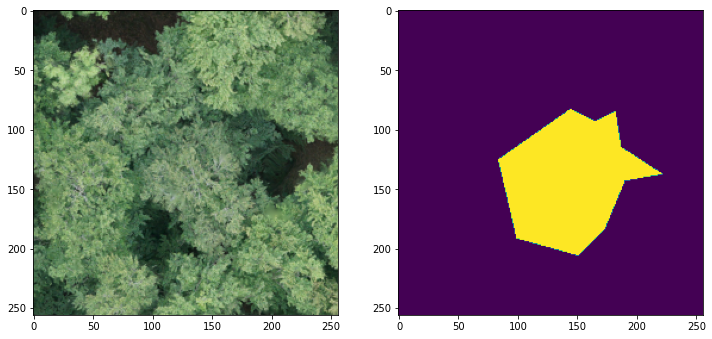

In [17]:
image_number = random.randint(0, len(img_dataset)) # select random image number 
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(img_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(msk_dataset[image_number], (patch_size, patch_size, 1)))
plt.show()

In [18]:
%%time
#Normalize images
image_dataset = normalize(np.array(img_dataset), axis=1)
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.array(msk_dataset)

CPU times: user 3.07 s, sys: 7.46 s, total: 10.5 s
Wall time: 15.3 s


### Split dataset into train (90%) and test (10%) data: 

In [34]:
%%time
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

CPU times: user 293 ms, sys: 4.13 s, total: 4.43 s
Wall time: 24.5 s


## 2. U-net Model Architecture

In [35]:
## Image shape paramters
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

print(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

256 256 3


### Import Model Architecture: 

In [36]:
## Import unet model for transfer learning 
def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS) # reshape to our Image shape 

model = get_model()

## print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

## 3. Compile and Train U-net Model

### Tuning Parameter:

In [37]:
## compiling parameter
optimizer = 'adam'
loss_function = 'binary_crossentropy'

## training parameter
batch_size = 16
epochs = 10


### Compile the model: 

In [38]:
model.compile(optimizer = optimizer, loss = loss_function, metrics=['accuracy'])

### Train the model:

In [39]:
%%time
## Train the model 
history = model.fit(X_train, y_train, 
                    batch_size = batch_size, #number of batches 
                    verbose = 1, 
                    epochs = epochs, #number of interations
                    validation_data = (X_test, y_test), 
                    shuffle = False)

## save the model 
model.save('model_tree_crowns.hdf5') 

Epoch 1/10
191/191 [==============================] - 67s 341ms/step - loss: 0.3506 - accuracy: 0.8323 - val_loss: 0.2822 - val_accuracy: 0.8995
Epoch 2/10
191/191 [==============================] - 55s 289ms/step - loss: 0.2661 - accuracy: 0.9027 - val_loss: 0.2505 - val_accuracy: 0.9019
Epoch 3/10
191/191 [==============================] - 55s 288ms/step - loss: 0.2454 - accuracy: 0.9042 - val_loss: 0.2387 - val_accuracy: 0.9037
Epoch 4/10
191/191 [==============================] - 54s 285ms/step - loss: 0.2394 - accuracy: 0.9064 - val_loss: 0.2353 - val_accuracy: 0.9074
Epoch 5/10
191/191 [==============================] - 54s 285ms/step - loss: 0.2278 - accuracy: 0.9112 - val_loss: 0.2212 - val_accuracy: 0.9129
Epoch 6/10
191/191 [==============================] - 59s 309ms/step - loss: 0.2159 - accuracy: 0.9155 - val_loss: 0.2116 - val_accuracy: 0.9168
Epoch 7/10
191/191 [==============================] - 55s 290ms/step - loss: 0.2051 - accuracy: 0.9198 - val_loss: 0.2096 - val_ac

## 4. Model Validation

### Internal validation with test data:

In [40]:
## evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

24/24 [==============================] - 3s 136ms/step - loss: 0.2103 - accuracy: 0.9202
Accuracy =  92.02338457107544 %


### Predict test data: 

We use the Area over Union (IoU) for Validation. It describes the intersection of the labelled and the predicted areas. 

In [41]:
## predict test data for evalutation 
#Intersection over Union (IoU)
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.7

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


24/24 [==============================] - 3s 135ms/step
IoU socre is:  0.5765915488133296


## 5. Plot results

1/1 [==============================] - 0s 14ms/step


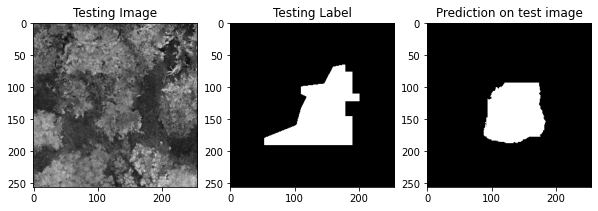

In [60]:
test_img_number = random.randint(0, len(X_test)) # grab random image number for plotting 
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8) # prediction for selected image 


## plot image, label and prediction 
plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')